# Adam Trentowski - 162602 - Machine Learning
## lab_13
## Library Imports

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

## Choosing processing unit

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data download and transform

In [5]:
train_set = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

test_set = torchvision.datasets.MNIST(
    root='./data/MNIST',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.73MB/s]


## Defining dataloading modules

In [6]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=True)

## Interation in batch (for progress of batches)

In [8]:
sample = next(iter(train_set))
image = sample[0]
label = sample[1]
image.shape

torch.Size([1, 28, 28])

## Visualizing the dataset

In [10]:
images = []
labels = []
for i, (image, label) in enumerate(trainloader):
    if i == 0:
        images, labels = image, label
        break

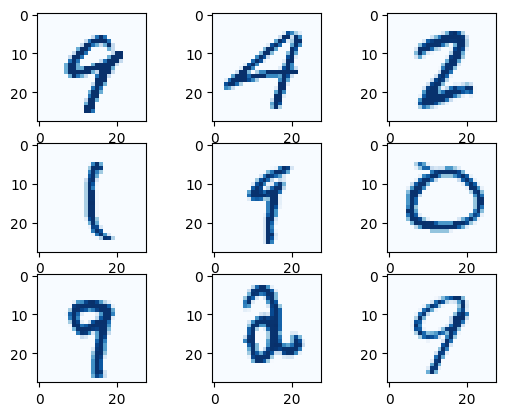

In [11]:
n = 9
for index in range(1, n + 1):
  plt.subplot(3, 3, index)
  plt.imshow(images[index].numpy().squeeze(), cmap='Blues')

## Creating CNN

In [13]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Creating object of network

In [14]:
network = Network()

## Defining loss, learning rate and optimizer

In [15]:
network.to(device)

# defining the Loss
error = nn.CrossEntropyLoss()

## defining the Lr and optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

## Network training

In [18]:
network.cpu()

num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(64, 1, 28, 28))
        labels = Variable(labels)

        outputs = network(train)
        loss = error(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(64, 1, 28, 28))
                outputs = network(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            if not (count % 50):
                print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 50, Loss: 0.04952568560838699, Accuracy: 98.77804565429688%
Iteration: 100, Loss: 0.03193007782101631, Accuracy: 98.79808044433594%
Iteration: 150, Loss: 0.008555353619158268, Accuracy: 98.74799346923828%
Iteration: 200, Loss: 0.016673462465405464, Accuracy: 98.84815979003906%
Iteration: 250, Loss: 0.005197218619287014, Accuracy: 98.70793151855469%
Iteration: 300, Loss: 0.009294908493757248, Accuracy: 98.70793151855469%
Iteration: 350, Loss: 0.006637761369347572, Accuracy: 98.60777282714844%
Iteration: 400, Loss: 0.02836209535598755, Accuracy: 98.85816955566406%
Iteration: 450, Loss: 0.017914285883307457, Accuracy: 98.80809020996094%
Iteration: 500, Loss: 0.0003913528344128281, Accuracy: 98.81810760498047%
Iteration: 550, Loss: 0.008407152257859707, Accuracy: 98.60777282714844%
Iteration: 600, Loss: 0.02014019526541233, Accuracy: 98.85816955566406%
Iteration: 650, Loss: 0.006410832982510328, Accuracy: 98.88822174072266%
Iteration: 700, Loss: 0.02849770337343216, Accuracy: 98